# Part 3. Machine Learning


## Import libraries

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import warnings
import numpy as np
from numpy import array
warnings.filterwarnings('ignore')


In [5]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from pandas.plotting import autocorrelation_plot

In [6]:
np.random.seed(42)

## Data loading

In [7]:
bit_data=pd.read_csv('bit_data.csv',header=0, parse_dates=[0])

In [8]:
bit_data['Date'] = pd.to_datetime(bit_data['Date'])
bit_data.set_index('Date', inplace=True)

In [9]:
bit_data.tail()

,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,Return,Change,Volatility,MA7,MA21,Momentum,MACD,Signal,Upper_band,Lower_band
Date,,,,,,,,,,,,,,,,,,
2021-02-23 23:59:59,Bitcoin,BTC,54204.929756,45290.590268,54204.929756,48824.426869,1.061025e+11,9.099259e+11,-0.099,-5382.892196,10331.599596,53769.735433,47289.415827,56096.520513,4566.049082,4517.102742,59826.554174,34752.277479
2021-02-24 23:59:59,Bitcoin,BTC,51290.136695,47213.498162,48835.087661,49705.333316,6.369552e+10,9.263931e+11,0.018,880.906447,10213.074752,53420.639116,47871.951218,57536.943668,4126.268801,4438.935954,59604.211576,36139.690859
2021-02-25 23:59:59,Bitcoin,BTC,51948.966982,47093.853019,49709.082425,47093.853019,5.450657e+10,8.777661e+11,-0.053,-2611.480297,10021.835803,52765.504305,48356.131625,54204.319065,3526.365381,4256.421839,58977.804013,37734.459237
2021-02-26 23:59:59,Bitcoin,BTC,48370.785260,44454.842114,47180.464054,46339.760083,3.509679e+11,8.637523e+11,-0.018,-754.092936,9818.755354,51401.450933,48746.391302,48821.426869,2956.013517,3996.340175,58345.200144,39147.582461
2021-02-27 23:59:59,Bitcoin,BTC,48253.270101,45269.025766,46344.772237,46188.451275,4.591095e+10,8.609781e+11,-0.003,-151.308808,9616.167645,49985.583899,49076.031328,49702.333316,2463.399661,3689.752072,57737.084195,40414.978460


In [10]:
binary = lambda data: [1 if x > 0 else 0 for x in data]

## 1. Baseline Model

Baseline model would serve as a benchmark for comparing to more complex models.

In [11]:
def baseline_model(stock):
    '''
    \n\n
    Input: Series or Array
    Returns: Accuracy Score
    Function generates random numbers [0,1] and compares them with true values
    \n\n
    '''
    baseline_predictions = np.random.randint(0, 2, len(stock))
    accuracy = accuracy_score(binary(bit_data.Return), baseline_predictions)
    return accuracy

## Accuracy


In [12]:
baseline_accuracy = baseline_model(bit_data.Return)
print('Baseline model accuracy: {:.1f}%'.format(baseline_accuracy * 100))

Baseline model accuracy: 48.0%


## Accuracy Distribution

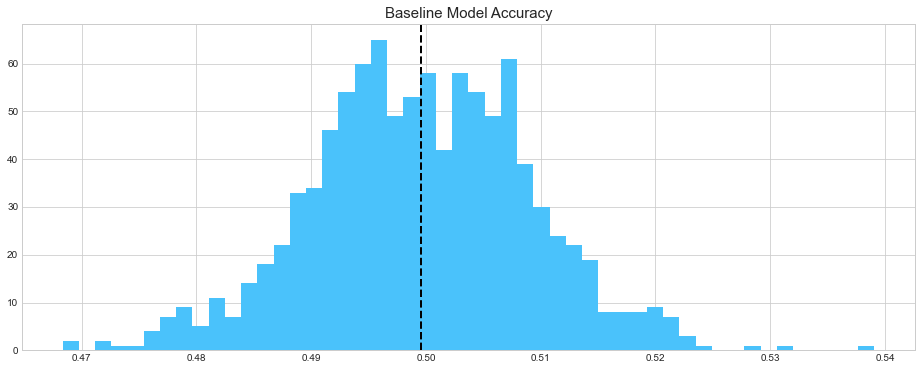

In [13]:
base_preds = []
for i in range(1000):
    base_preds.append(baseline_model(bit_data.Return))
    
plt.figure(figsize=(16,6))
plt.style.use('seaborn-whitegrid')
plt.hist(base_preds, bins=50, facecolor='#4ac2fb')
plt.title('Baseline Model Accuracy', fontSize=15)
plt.axvline(np.array(base_preds).mean(), c='k', ls='--', lw=2)
plt.show()

## Conclusion

Baseline model on average has 50% accuracy. We take this number as a guideline for our more complex models


## 2. ARIMA


AutoRegressive Integrated Moving Average (ARIMA) is a model that captures a suite of different standard temporal structures in time series data.

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

We will split train and test data to evaluate performance of ARIMA model.

In [14]:
print('Bitcoin historical data contains {} entries'.format(bit_data.shape[0]))
bit_data[['Return']].head()

Bitcoin historical data contains 2842 entries


,Return
Date,
2013-05-19 23:59:59,-0.010
2013-05-20 23:59:59,-0.004
2013-05-21 23:59:59,0.007
2013-05-22 23:59:59,0.008
2013-05-23 23:59:59,0.023


## Autocorrelation

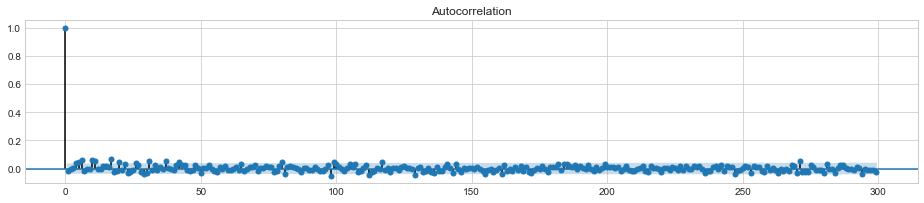

In [15]:
plt.rcParams['figure.figsize'] = (16, 3)
plot_acf(bit_data.Return, lags=range(300))
plt.show()

Let's take a look at the Autocorrelation Function. The graph shows how time series data points correlate between each other. We should ignore first value in the graph that shows perfect correlation (value = 1), because it tells how data point is correlated to itself. What's important in this graph is how first data point is correlated to second, third and so on. We can see that it's so weak, it's close to zero. What does it mean to our analysis? It means that ARIMA is pretty much useless here, because it uses previous data points to predict following.

To make a conclusion we're going to try different orders and see how well they perform on a given data

In [16]:
# ARIMA orders
orders = [(0,0,0),(1,0,0),(0,1,0),(0,0,1),(1,1,0)]

# Splitting into train and test sets
train = list(bit_data['Return'][1000:2300].values)
test = list(bit_data['Return'][2300:2800].values)

all_predictions = {}

for order in orders:
    
    try:
        # History will contain original train set, 
        # but with each iteration we will add one datapoint
        # from the test set as we continue prediction
        history = train.copy()
        order_predictions = []
        
        for i in range(len(test)):
            
            model = ARIMA(history, order=order) # defining ARIMA model
            model_fit = model.fit(disp=0) # fitting model
            y_hat = model_fit.forecast() # predicting 'return'
            order_predictions.append(y_hat[0][0]) # first element ([0][0]) is a prediction
            history.append(test[i]) # simply adding following day 'return' value to the model    
            print('Prediction: {} of {}'.format(i+1,len(test)), end='\r')
        
        accuracy = accuracy_score( 
            binary(test), 
            binary(order_predictions) 
        )        
        print('                             ', end='\r')
        print('{} - {:.1f}% accuracy'.format(order, round(accuracy, 3)*100), end='\n')
        all_predictions[order] = order_predictions
    
    except:
        print(order, '<== Wrong Order', end='\n')
        pass

(0, 0, 0) - 51.8% accuracy   
(1, 0, 0) - 51.4% accuracy   
(0, 1, 0) - 46.0% accuracy   
(0, 0, 1) - 51.6% accuracy   
(1, 1, 0) - 50.6% accuracy   


## Review Predictions

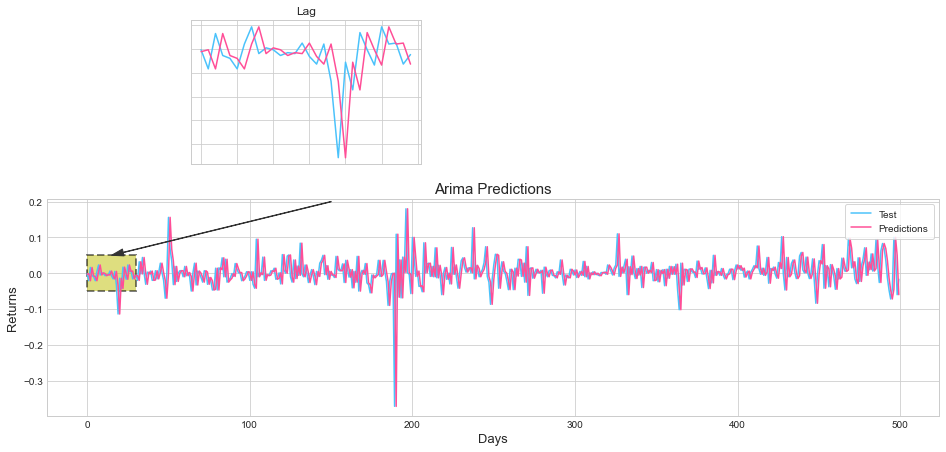

In [17]:
# Big Plot
fig = plt.figure(figsize=(16,4))
plt.plot(test, label='Test', color='#4ac2fb')
plt.plot(all_predictions[(0,1,0)], label='Predictions', color='#ff4e97')
plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
plt.title('Arima Predictions', fontSize=15)
plt.xlabel('Days', fontSize=13)
plt.ylabel('Returns', fontSize=13)

# Arrow
plt.annotate('',
             xy=(15, 0.05), 
             xytext=(150, .2), 
             fontsize=10, 
             arrowprops={'width':0.4,'headwidth':7,'color':'#333333'}
            )
# Patch
ax = fig.add_subplot(1, 1, 1)
rect = patches.Rectangle((0,-.05), 30, .1, ls='--', lw=2, facecolor='y', edgecolor='k', alpha=.5)
ax.add_patch(rect)

# Small Plot
plt.axes([.25, 1, .2, .5])
plt.plot(test[:30], color='#4ac2fb')
plt.plot(all_predictions[(0,1,0)][:30], color='#ff4e97')
plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.title('Lag')
plt.show()

## Histogram

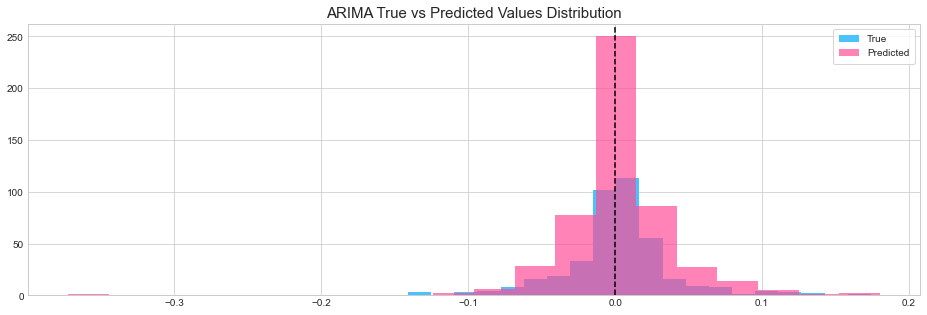

In [18]:
plt.figure(figsize=(16,5))
plt.hist(bit_data[1900:2300].reset_index().Return, bins=20, label='True', facecolor='#4ac2fb')
plt.hist(all_predictions[(0,1,0)], bins=20, label='Predicted', facecolor='#ff4e97', alpha=.7)
plt.axvline(0, c='k', ls='--')
plt.title('ARIMA True vs Predicted Values Distribution', fontSize=15)
plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
plt.show()

## Interpreting Results

In [19]:
test_binary = binary(bit_data[2300:2800].reset_index().Return)
train_binary = binary(all_predictions[(0,1,0)])
tn, fp, fn, tp = confusion_matrix(test_binary, train_binary).ravel()
accuracy = accuracy_score(test_binary, train_binary)

print("True positive and Negative: {}".format((tp + tn)))
print("False Positive and Negative: {}".format((fp + fn)))
print("Accuracy: {:.1f}%".format(accuracy*100))

True positive and Negative: 230
False Positive and Negative: 270
Accuracy: 46.0%


## Using MACD to Make Decision

In [20]:
def trading_history(stock, net, std=2):    
    
    # Bollinger band plot with EMA and original historical data
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.MA21, color='#ad6eff', label='Moving Average (21 days)')
    plt.plot(stock.index, stock.Upper_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.Lower_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.Upper_band, stock.Lower_band, color='#ffa33f', alpha=0.1, label='Bollinger Band ({} STD)'.format(std))
    
    plt.title('Trading History', fontSize=15)
    plt.ylabel('Price', fontSize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    
    for i in net:
        if i[2] == 1: color = '#ff005e'
        else: color = '#4bd81d'
        plt.plot_date(i[0], i[1], color=color)
        
    plt.plot_date([],[],label='Buy', c='#ff005e')
    plt.plot_date([],[],label='Sell', c='#4bd81d')
        
    plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
    plt.show()

In [21]:
def macd_trading(stock, budget=15000, show_graph=True, show_return=True):
    
    state_check = lambda x, y: 1 if x > y else 0
    stock = stock.reset_index()    
    money = budget
    prev_state = state_check(stock.loc[0].MACD, stock.loc[0].Signal)
    stock_amt = 0
    net = []

    for i in range(1, len(stock)):

        today = stock.iloc[i]
        state = state_check(today.MACD, today.Signal)

        if state != prev_state:

            # BUY
            if (today.MACD > today.Signal) and (money != 0):
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

            # SELL
            if (today.MACD < today.Signal) and (stock_amt != 0):
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])

        prev_state = state
    
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net    

Number of Trades: 18
Time Frame: 333 days
Profit: $84747.60 | 564.98%


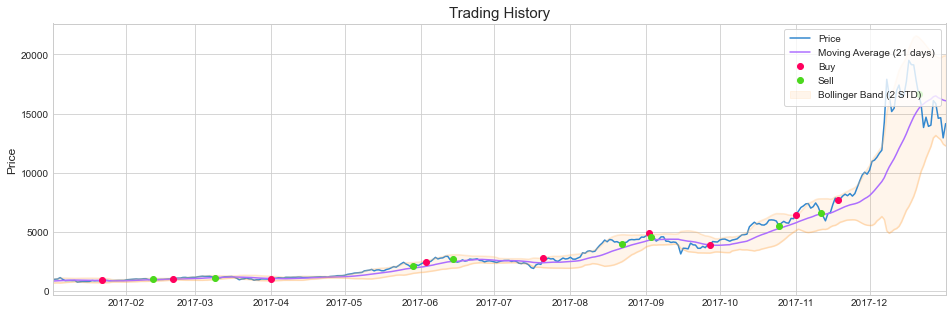

In [62]:
profit, trades = macd_trading(bit_data.loc['2017':'2017'])

In [59]:
def macd(stock):
    # MACD
    plt.figure(figsize=(16,2))
    plt.plot(stock.MACD, label='MACD', color = '#b278ff')
    plt.plot(stock.Signal, label='Signal', color='#ffa74a')
    plt.axhline(0, color='#557692')
    plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
    plt.title('MACD', fontSize=15)
    plt.ylabel('Strength', fontSize=12)
    plt.show()  

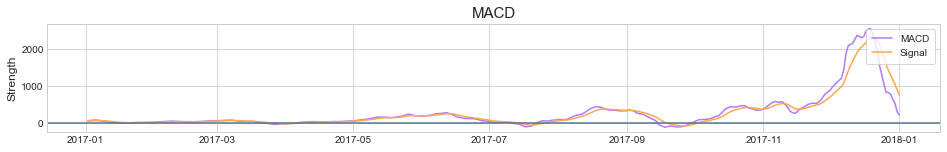

In [60]:
macd(bit_data.loc['2017':'2017'])

## Using Bollinger Bands to Make Decision

In [61]:
def bb_trading(stock, budget=15000, u=0.03, l=0.03, show_graph=True, show_return=True):
    
    money = budget
    stock = stock.reset_index()
    net = []
    for i in range(len(stock)):
        today = stock.iloc[i]
        
        # Buy
        if (today.Close < today.MA21) and (abs(1 - today.Close / today.Lower_band) < u):
            if money > 0:
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

        # Sell        
        if (today.Close > today.MA21) and (abs(1 - today.Upper_band / today.Close) < l):
            if money == 0:
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])
        
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net

Number of Trades: 2
Time Frame: 20 days
Profit: $3437.66 | 22.92%


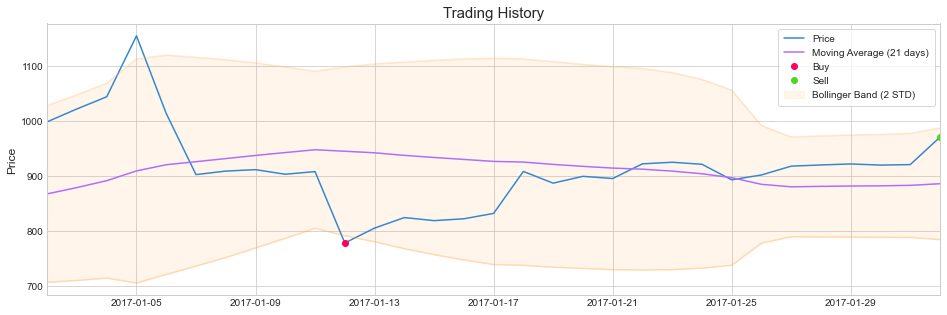

In [117]:
profit, trades = bb_trading(bit_data.loc['2017-01':'2017-01'], u=0.03, l=0.03)